# Testing different sampling rates

If we want to use `lisainstrument` and `pyTDI` for long-lasting signals, we might not be interested in high sampling rates. So this is to find out if and how we can use lower sampling rates.

In [187]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy as sp

import lisaorbits
import lisaglitch
import lisainstrument
import lisagwresponse
import pytdi


from pytdi.michelson import X2, Y2, Z2
from pytdi.ortho import A2, E2, T2
from pytdi.sagnac import ALPHA2, BETA2, GAMMA2,ZETA21, ZETA22, ZETA23

import os

mpl.rcParams['figure.figsize']=(9,6)
mpl.rcParams['font.size'] = 14

def create_plots(ncols=1, nrows=1, **kwargs):
    '''
    Standard function to create plots of a reasonable size 
    '''
    
    # readout the standard parameters
    fs = mpl.rcParams['figure.figsize']

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*fs[0],nrows*fs[1]), **kwargs)
    
    return fig, ax

## Creating an orbit

We create an orbit lasting for a a few years with a relatively low sampling rate - 10 samples per day. We set `t0` and `size` such that the orbit extends a sample beyond the "core" times. That makes it easier later to create the signals.

In [188]:
years=4
dt = 8640.
t = np.arange( 0, years*365*86400+dt, dt)
orb_t = np.arange(t[0]-dt, t[-1]+dt, dt )
orbits = lisaorbits.KeplerianOrbits(dt=dt,size=orb_t,t0=t[0]-dt, t =orb_t )
orbits.tau0 = orbits.t0

if os.path.isfile("orbits.h5"):
    os.remove( "orbits.h5")
orbits.write("orbits.h5")

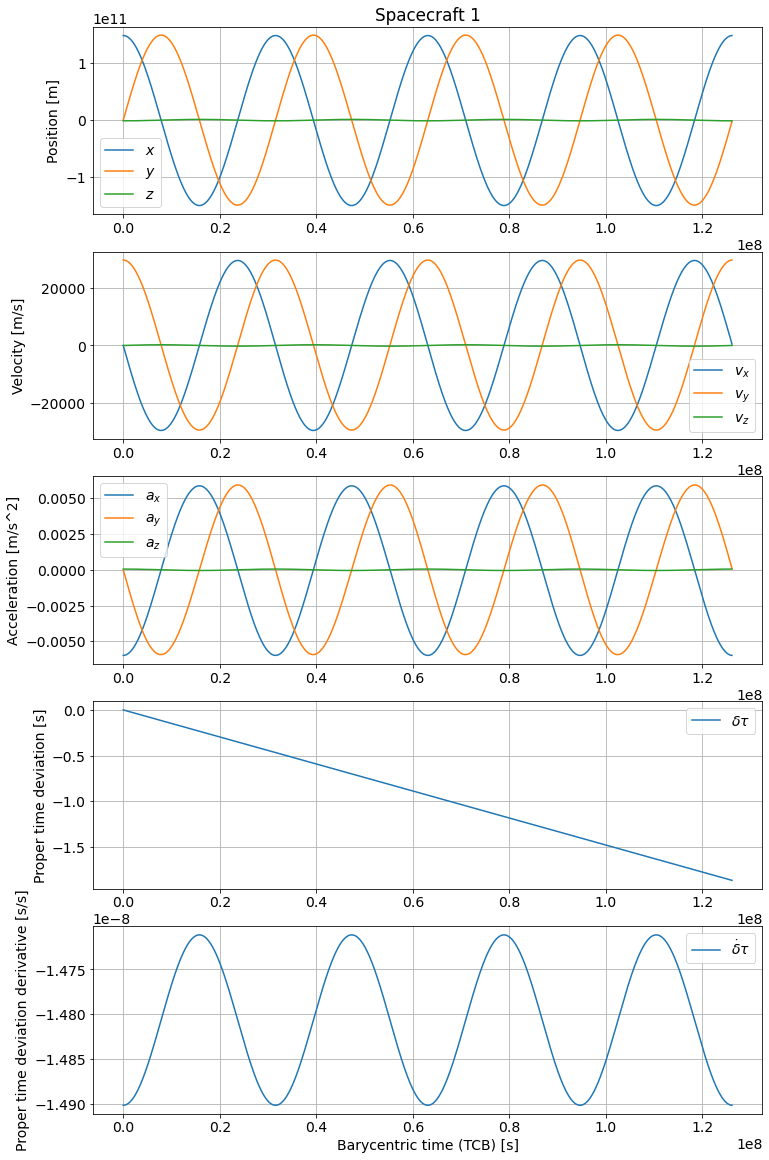

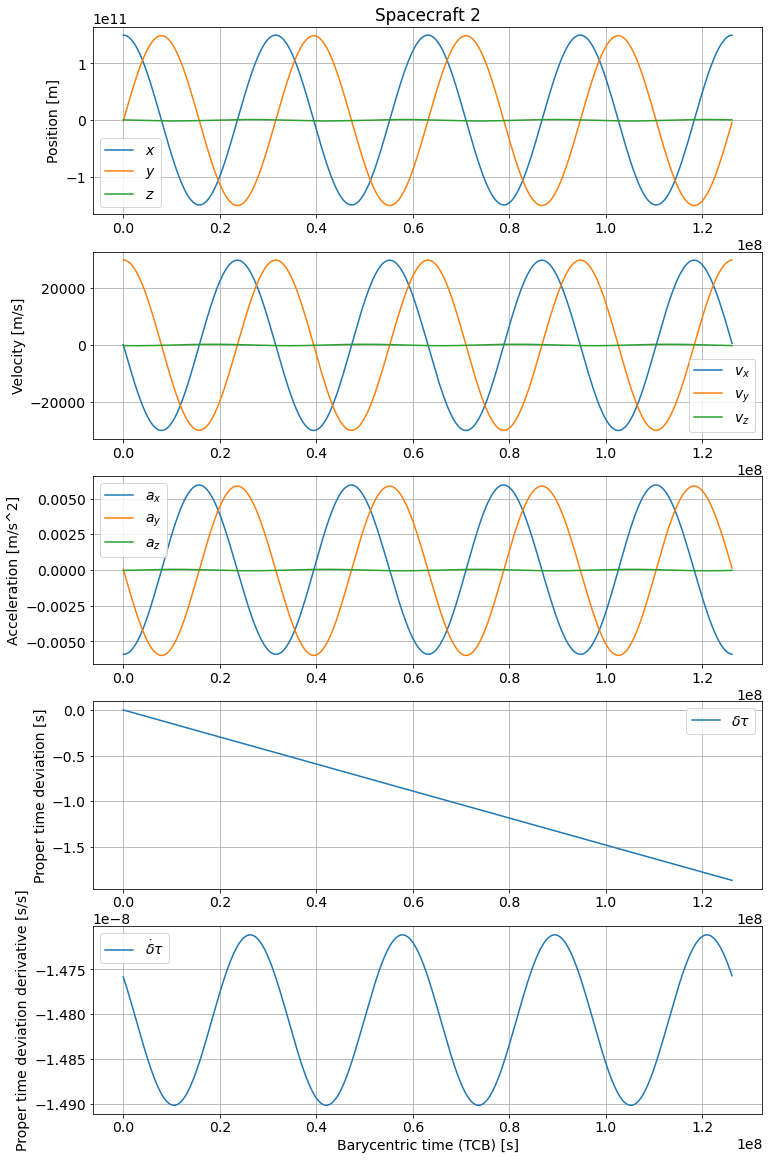

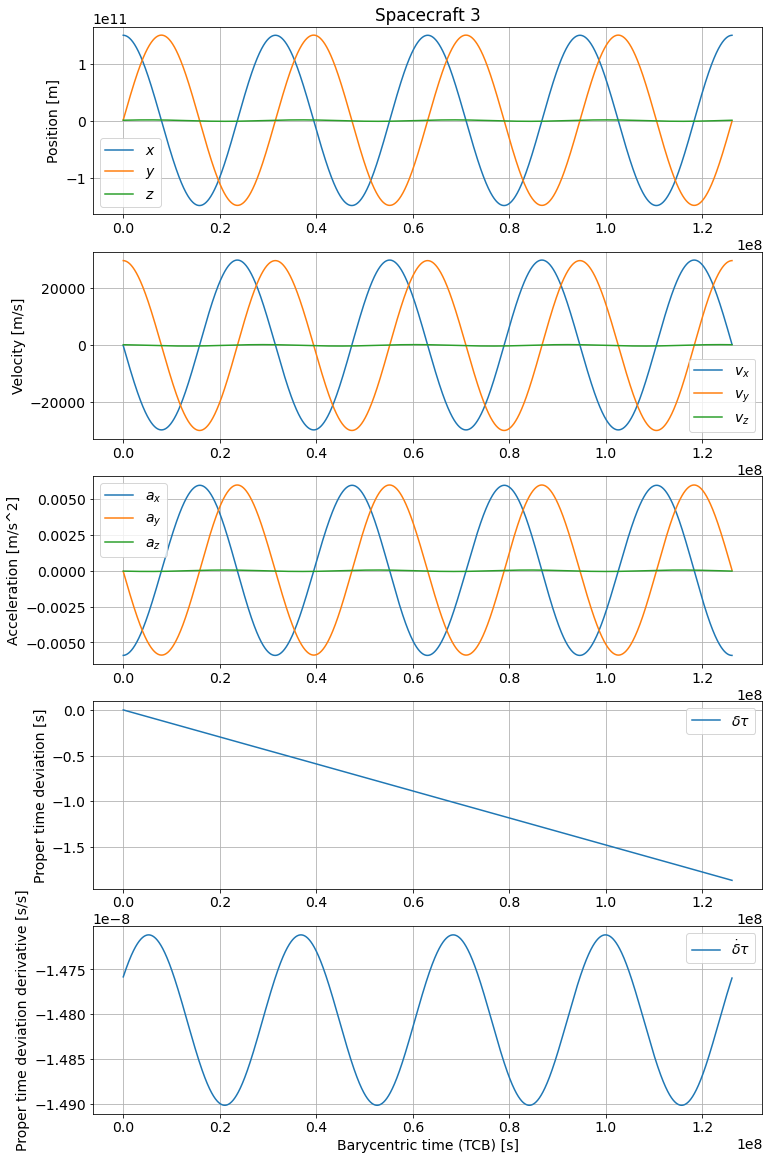

In [189]:
for sc in [1,2,3]:
    orbits.plot_spacecraft(sc,output=f'Plots/sc{sc}.pdf')

So the orbits are reasonably well sampled. Now let's build a signal

# Creating a GW signal from a binary

Pick a typical binary frequency - we use 4 mHz. So we need to have a somewhat higher sampling frequency - let's pick 10 mHz, i.e `dt` will be 100s. This should give us about $10^6$ sampling points in 4 years. In the creation of the stain be carful to stay away from the "edges" of the orbit. The interpolator thors an error if the values are outside the dowain, so make sure the `t0` for the binary is larger than the `t0` for the orbit and also that the last requested time is maller than th elast time available in the orbit. This means that `size` has to be accordingly set.

In [66]:
lisagwresponse.GWResponse?

Init signature: lisagwresponse.GWResponse(dt=0.3, size=259200, t0=0)
Docstring:     
Abstract base class representing a GW source.

Sampling parameters (``dt``, ``size``, and ``t0``) are used to generate when creating a GW file.
Note that they are ignored when writing to an existing GW file.

Args:
    dt (float): simulation sampling period [s]
    size (int): simulation size [samples]
    t0 (int): simulation initial time [s]
File:           ~/.conda/envs/LISA/lib/python3.9/site-packages/lisagwresponse/core.py
Type:           ABCMeta
Subclasses:     ReadGWResponse, Strain, StochasticBackground


In [176]:
gw_dt = 100
gw_t0 = 0
gw_size = int( years*365*86400/gw_dt  ) 

In [269]:
gw_galbin = lisagwresponse.GalacticBinary( 1e-18, 4e-3, 
                                          orbits="orbits.h5", gw_lambda=0, gw_beta=0, dt=gw_dt, 
                                          t0=gw_t0, size = gw_size )
gw_galbin.version = '1.0'

/Users/oliver jennrich/.conda/envs/LISA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


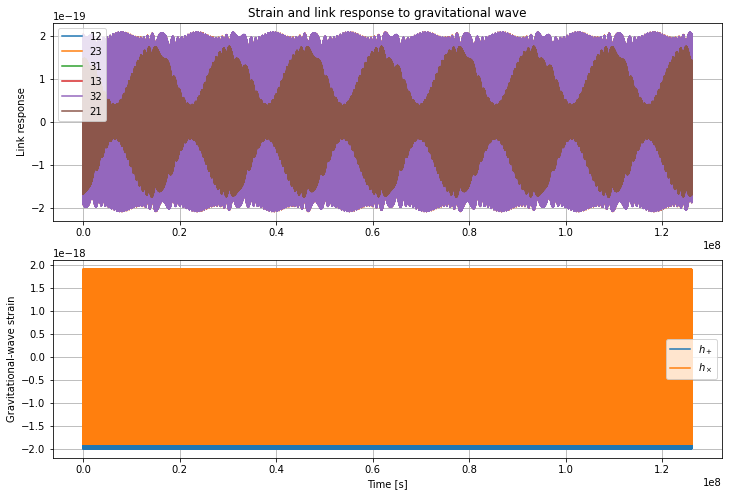

In [180]:
gw_galbin.plot()

Write the signal into a file.

In [273]:
print(gw_galbin.version)
gw_galbin.write("gw_galbin.h5")

1.0


If we plot the effect on the arm for e.g. a year, we see the amplitude modulation of the signal due to the orbital motion very clearly.

Text(0.5, 1.0, 'Signal in arm 31')

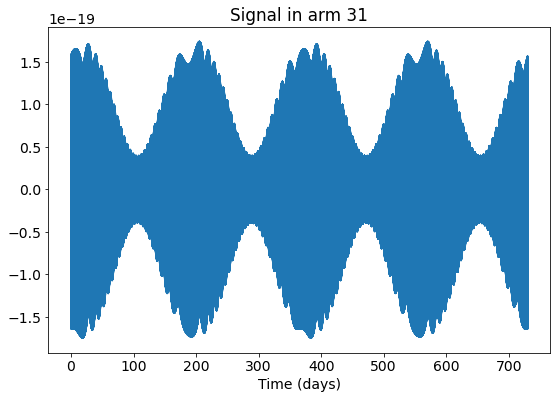

In [688]:
ix = np.where( gw_galbin.t<= 2*365*86400)
fig, ax = create_plots()

ax.plot( gw_galbin.t[ix]/86400,gw_galbin.compute_gw_response('31',gw_galbin.t[ix]).transpose() )
ax.set_xlabel( 'Time (days)' )
ax.set_title('Signal in arm 31')

Text(0.5, 0, 'Frequency (Hz)')

<ipython-input-683-15c1d2cad2fd>:6: RuntimeWarning: divide by zero encountered in true_divide
  secax = ax.secondary_xaxis('top',functions=(lambda x: 1/(86400*x), lambda x: 1/(86400*x)))


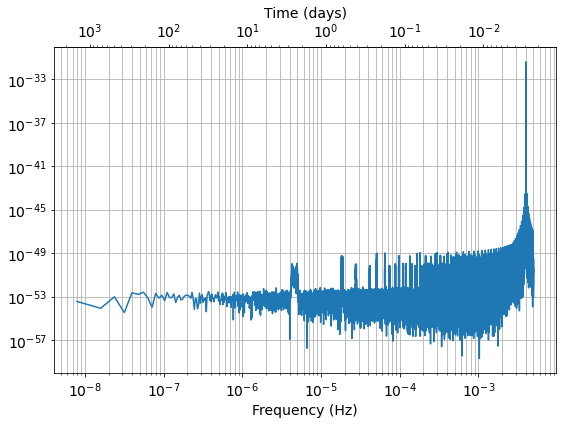

In [683]:
from scipy.signal import periodogram

fig, ax = create_plots()
ff, psd = periodogram( gw_galbin.compute_gw_response('12',gw_galbin.t).flatten() , fs = 1/gw_dt, window='nuttall', detrend=False)
ax.loglog( ff[1:], psd[1:] )
secax = ax.secondary_xaxis('top',functions=(lambda x: 1/(86400*x), lambda x: 1/(86400*x)))
secax.set_xlabel('Time (days)')
ax.grid(axis='both', which='both')
ax.set_xlabel("Frequency (Hz)")

If one zooms all the way in, the orbital side-bands become visible. They sit at about $3\times10^{-7}$ and twice that, reflecting the yearly and twice-yearly variation of the signal

Text(0.5, 0, 'frequency relative to 4mHz')

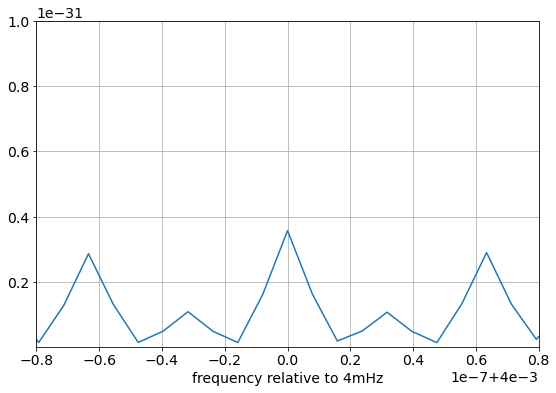

In [689]:
from scipy.signal import periodogram
fig, ax = create_plots()
ax.plot( *periodogram( gw_galbin.compute_gw_response('12',gw_galbin.t).flatten() , fs = 1/gw_dt, window='nuttall', detrend=False) )
#ax.secondary_xaxis('top',functions=(lambda x: 1/(86400*x), lambda x: 1/(86400*x)))
ax.grid(axis='both', which='both')
ax.set_yscale('linear')
ax.set_xlim([(1-2e-5)*4e-3,(1+2e-5)*4e-3])
ax.set_ylim([1e-34,1e-31])
ax.set_xlabel( "frequency relative to 4mHz")

Now that we have the signal with enough sampling points, we can build a number of instruments. We start with a relatively small number of seconds, to see the effect. We build two instruments, one with noise, and one without, so that we can see if we can recover the signal with TDI

In [393]:
lisainstrument.Instrument?

Init signature:
lisainstrument.Instrument(
    size=2592000,
    dt=0.25,
    t0='orbits',
    physics_upsampling=4,
    aafilter=('kaiser', 240, 1.1, 2.9),
    telemetry_downsampling=345600,
    telemetry_t0='orbits',
    orbits='static',
    orbit_dataset='tps/ppr',
    gws=None,
    interpolation=('lagrange', 31),
    glitches=None,
    lock='N1-12',
    offsets_freqs='default',
    laser_asds=28.2,
    central_freq=281600000000000.0,
    modulation_asds='default',
    modulation_freqs='default',
    tdir_tone=None,
    clock_asds=6.32e-14,
    clock_offsets=0,
    clock_freqoffsets='default',
    clock_freqlindrifts='default',
    clock_freqquaddrifts='default',
    clockinv_tolerance=1e-10,
    clockinv_maxiter=5,
    backlink_asds=3e-12,
    backlink_fknees=0.002,
    testmass_asds=2.4e-15,
    testmass_fknees=0.0004,
    oms_asds=(6.35e-12, 1.25e-11, 1.42e-12, 3.38e-12, 3.32e-12, 7.9e-12),
    oms_fknees=0.002,
    sync_asds=0.0022,
    ttl_coeffs='default',
    sc_jitter_asds=(

## TDI with default parameters

We start this by establishing a baseline - create twoinstruments, one with and one without noise with the 'normal' sampling rate of 4 Hz. 

In [529]:
dt = 0.25
t0 = 0
measurement_time = 1.2e4
instrument = lisainstrument.Instrument(dt=dt,size=measurement_time/dt, t0=t0,
                                       lock = 'six',
                                       orbits='orbits.h5',
                                       gws="gw_galbin.h5")

instrument0 = lisainstrument.Instrument(dt=dt,size=measurement_time/dt, t0=t0,
                                        lock = 'six',
                                        orbits='orbits.h5',
                                        gws="gw_galbin.h5")

In [530]:
instrument0.disable_all_noises()

instrument0.simulate()
instrument.simulate()

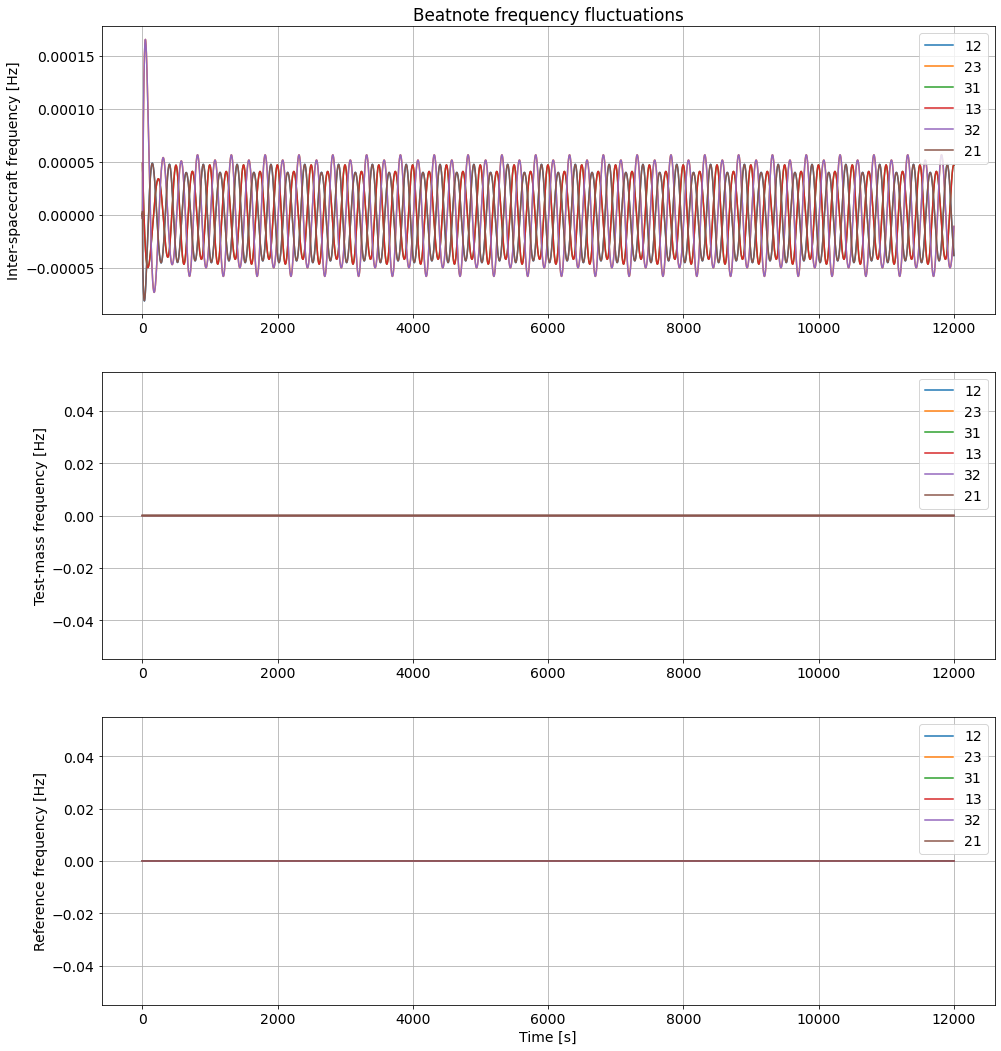

In [531]:
instrument0.plot_fluctuations()

#### Creating the TDI combination.

We calculate all possible combinations so that we can compare the performance. 

In [532]:
names = ['X','Y','Z','A','E','T', 'α', 'β', 'γ', 'ζ_1', 'ζ_2', 'ζ_3']
signals = [X2,Y2,Z2, A2,E2,T2, ALPHA2, BETA2, GAMMA2, ZETA21, ZETA22, ZETA23]

In [533]:
data0 = pytdi.Data.from_instrument(instrument0)
data = pytdi.Data.from_instrument(instrument)

In [534]:
signal={}
for k, (p,name) in enumerate( zip(signals , names)):
    built=p.build(**data.args)
    signal[name] =  built(data.measurements)

In [535]:
signal0={}
for k, (p,name) in enumerate( zip(signals , names)):
    built=p.build(**data0.args)
    signal0[name] =  built(data0.measurements)

#### Filtering the data

We also need to low-pass filter the data, otherwise the PSD are dominated by the high-frequency noise and not reliable. We use an FIR filter as they are less prone to ringing. The actual fitering is done by `filtfilt`


In [557]:
from scipy.signal import firls,lfilter, filtfilt

fir_firls= firls(241, (0,  0.5, 1, 2), (1, 1, 1e-8, 1e-12), fs=1/dt)

for k,s  in signal.items():
    signal[k] =  filtfilt(fir_firls, [1.0], s)
    
for k,s  in signal0.items():
    signal0[k] =  filtfilt(fir_firls, [1.0], s)

As usual, we need to skip the first few points in the data, as the filter need some samples to work properly. The number here is chosen heuristically, ie we increased it until we see no large excursions at the start of the data.

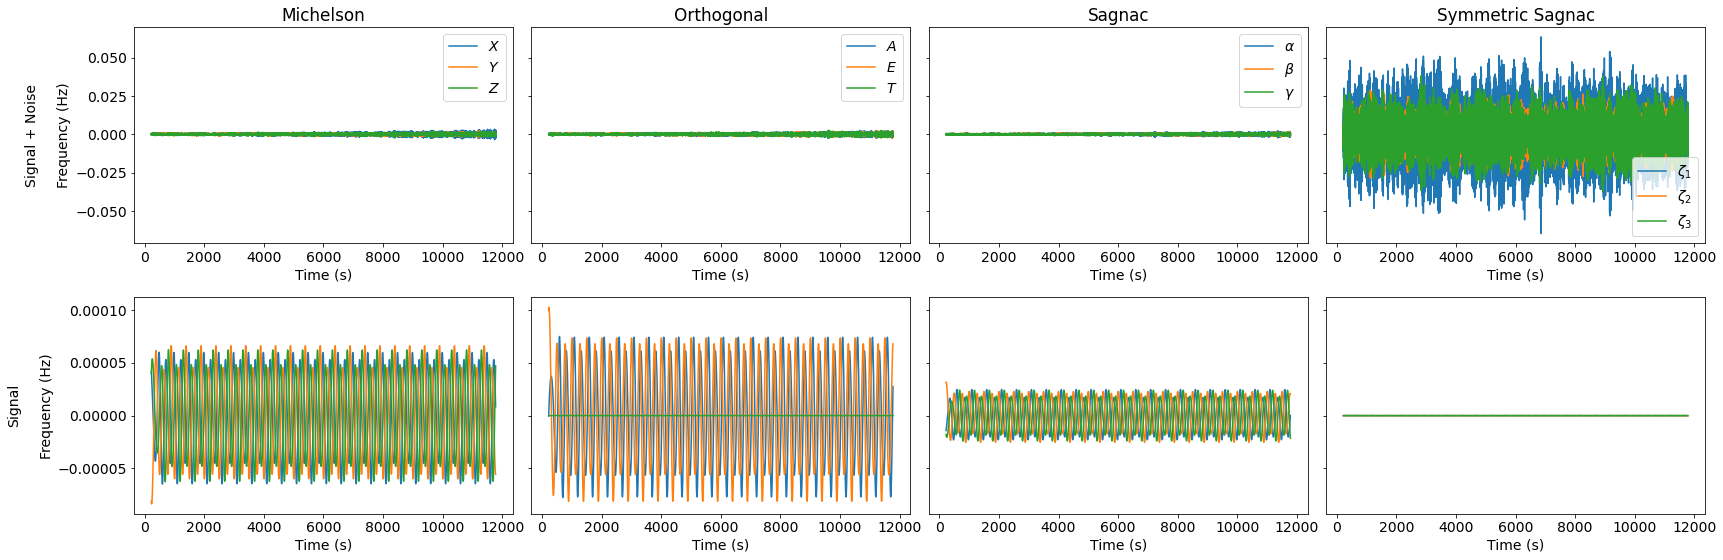

In [563]:
fig,axes = plt.subplots(ncols=len(names)//3,nrows=2,figsize=(6*len(names)//3,4*2),sharey='row')
  
coltitle = ['Michelson', 'Orthogonal', 'Sagnac', 'Symmetric Sagnac']
rowtitle = ['Signal + Noise', 'Signal']

offs=900

for ins, s,ax  in zip( [instrument, instrument0], [signal, signal0], axes ):
    for k, name in enumerate( names ):
        ax[k//3].plot( ins.t[offs:-offs], s[name][offs:-offs], label=rf'${name}$')

    for axx,ct  in zip(axes[0], coltitle):
        axx.set_title(ct)
        # axx.set_xlim([-0.1,50000*1e-6])
        axx.set_xlabel("Time (s)")
        axx.legend()
    

    
for ax, col in zip(axes[0],coltitle):
    ax.set_title(col)
    ax.legend()
    
for ax in axes[-1]:
    ax.set_xlabel('Time (s)')
    
for ax,row in zip(axes[:,0],rowtitle):
    ax.set_ylabel(f'{row}\n\nFrequency (Hz)')
   
    
fig.tight_layout()

#### Calculating the PSD

We use the `periodogram` function for the calculation of the spectra. We use the asame data as above, i.e shorten the data by some points on both ends.

In [566]:
sf={}
offs=900
for sk,sv in signal.items():
    ssf = sv[offs:-offs]
    ff,sf[sk] = periodogram( ssf, fs=1/dt,  window='nuttall', scaling='density', detrend=False)
    
sf0={}

for sk,sv in signal0.items():
    ssf = sv[offs:-offs]
    ff,sf0[sk] = periodogram( ssf, fs=1/dt,  window='nuttall', scaling='density', detrend=False)

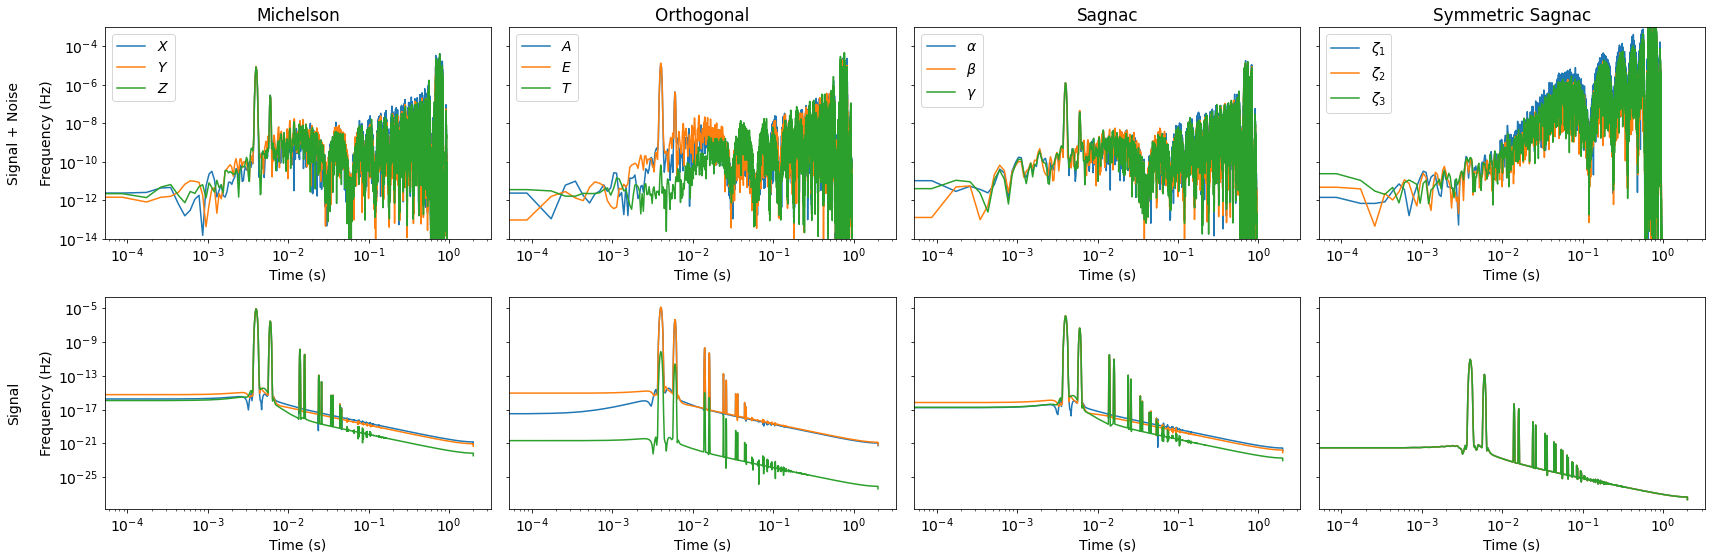

In [567]:
fig,axes = plt.subplots(ncols=len(names)//3,nrows=2,figsize=(6*len(names)//3,4*2),sharey='row')
  
coltitle = ['Michelson', 'Orthogonal', 'Sagnac', 'Symmetric Sagnac']
rowtitle = ['Signal + Noise', 'Signal']



for s,ax  in zip([sf, sf0], axes ):
    for k, name in enumerate( names ):
        ax[k//3].loglog( ff, s[name], label=rf'${name}$')

    for axx,ct  in zip(axes[0], coltitle):
        axx.set_title(ct)
        # axx.set_xlim([-0.1,50000*1e-6])
        axx.set_xlabel("Time (s)")
        axx.legend()
        axx.grid(axis='both', which='both')
    

    
for ax, col in zip(axes[0],coltitle):
    ax.set_title(col)
    ax.legend()
    ax.set_ylim([1e-14, 1e-3])
    
for ax in axes[-1]:
    ax.set_xlabel('Time (s)')
    
for ax,row in zip(axes[:,0],rowtitle):
    ax.set_ylabel(f'{row}\n\nFrequency (Hz)')
   
    
fig.tight_layout()

Ok, that looks fine. Significant peaks at the frequency of the binary and at twice the frequency in all combinations. The symmetric sagnac anc the $T$ channel have the signal significantly suppressed, which is to be expected.

### Investigating different sampling rates

Now do the same thing again, but with a number of different sampling frequencies. The signal is at 4mHz, so let's try the original 4 Hz as well as 2 Hz, 1 Hz, 0.1 Hz, 0.04 mHz, and 25.5 mHz, (or as the different sampling frequencies. 25.5 mHz seems to be the lowest sampling freqeuncy that is supported by the simulation as anything lower will yield an error. Not clear (yet) why that is, but we will see that such a low frequency ($6.375\times10^{-3}$ of the signal frequency)is not useful, as it leads to difficulties with the anti-aliasing filter in the simulation.

#### The anti-alias filter

We also need to adjust the ant-aliasing filter design, which is passed to the `Instrument` via the `aafilter` parameter. It needs to be adjusted to the sampling frequency. The original setting of `aafilter` is `aafilter=('kaiser', 240, 1.1, 2.9)` and if we scale that to the default sampling frequency it is `aafilter=('kaiser', 240, 0.275*df, 0.725*df)`. So we will use that scaling for the filter in the various instruments.

In [630]:

ins = {}
ins0 = {}
df_list = [4.0, 2.0, 1.0, 0.1, 0.04, 0.0255]

for df in df_list:
    ins[f'{df}'] = lisainstrument.Instrument(dt=1/df,size=measurement_time*df, t0=t0,
                          aafilter=('kaiser', 240, 0.275*df, 0.725*df),
                          orbits='orbits.h5',
                          gws="gw_galbin.h5")

    ins0[f'{df}'] = lisainstrument.Instrument(dt=1/df,size=measurement_time*df, t0=t0,
                          aafilter=('kaiser', 240, 0.275*df, 0.725*df),
                          orbits='orbits.h5',
                          gws="gw_galbin.h5")

for v in ins0.values():
    v.disable_all_noises()

Include a very rudimenatry error handling, to make sure that we know when things fails. 

In [631]:
for k,v in ins0.items():
    try: 
        v.simulate()
    except:
        print(f'Failed at sampling rate {k}')
    
for k,v in ins.items():
    try: 
        v.simulate()
    except:
        print(f'Failed at sampling rate {k}')

#### Run TDI on the different data

Prepare the data and build the data streams. This might take a while. While we are at it, we take the time it takes for computation to see the benefit of lower sampking rates.

In [632]:
data = {}
data0= {}

for k,v in ins0.items():
    data0[k] = pytdi.Data.from_instrument(v)
    
for k,v in ins.items():
    data[k] = pytdi.Data.from_instrument(v)

In [633]:
from time import time
time_elapsed = {}

In [634]:
sig0 = {}

for kk,v in data0.items():
    sig0[kk]={}
    fir = firls(241, (0,  0.125*v.fs, 0.25*v.fs, 0.5*v.fs), (1, 1, 1e-8, 1e-12), fs=v.fs)
    for k, (p,name) in enumerate( zip(signals , names)):
        built=p.build(**v.args)
        sig0[kk][name] =  lfilter( fir, [1.0], built(v.measurements))

In [635]:
sig = {}

for kk,v in data.items():
    sig[kk]={}
    fir = firls(241, (0,  0.125*v.fs, 0.25*v.fs, 0.5*v.fs), (1, 1, 1e-8, 1e-12), fs=v.fs)
    tstart = time()
    for k, (p,name) in enumerate( zip(signals , names)):
        built=p.build(**v.args)
        sig[kk][name] =  lfilter( fir, [1.0], built(v.measurements))
    time_elapsed[kk]=time()-tstart

Plot the elapsed time against the sampling rate. It should be roughly linear with the sampling rate, possibly a power law with an index close to 1:

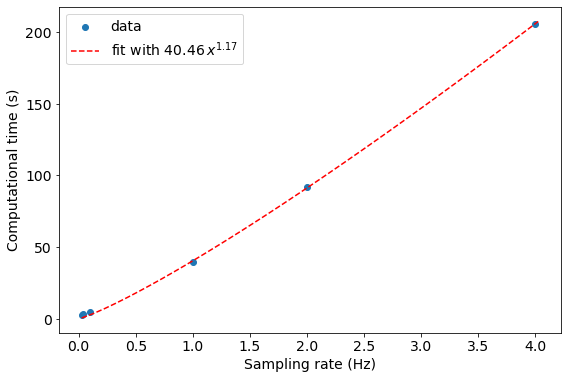

In [636]:
from scipy.optimize import curve_fit

t_elaps= np.array([ [float(k),v] for k,v in time_elapsed.items()]).transpose()

def fit_func( x, a,b ):
    return a*x**b

p = curve_fit(fit_func, *t_elaps, p0 = [50,1] )

fig,ax = create_plots()

ax.scatter( *np.array([ [float(k),v] for k,v in time_elapsed.items()]).transpose(), label='data')
t_elaps_x = np.arange(np.min(t_elaps[0]), np.max(t_elaps[0])+0.1, 0.1)
ax.plot( t_elaps_x, fit_func( t_elaps_x, *(p[0]) ) , linestyle='--', color='r', label=fr'fit with ${p[0][0]:.2f}\,x^{{ {p[0][1]:.2f} }}$')

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel("Sampling rate (Hz)")
ax.set_ylabel("Computational time (s)")

ax.legend()

Plot the time-series of the `X` signal and their spectra with and without noise.

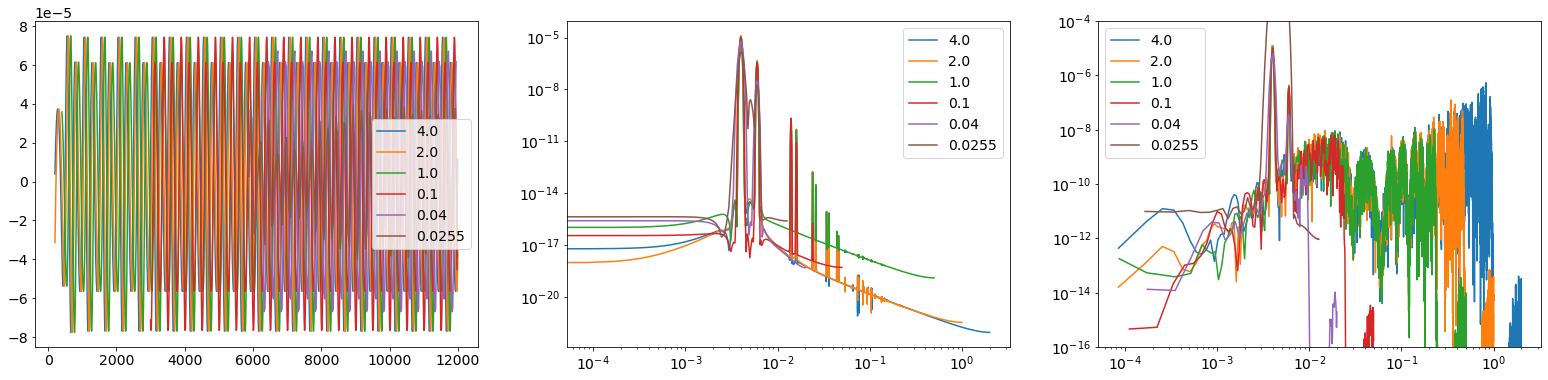

In [684]:
fig,ax = create_plots(ncols=3)

offs_dict = {'4.0': 800, '2.0': 400,'1.0':400, '0.1':300, '0.04':250, '0.0255':150}
for kk,v in sig0.items():
    offs = offs_dict[kk]
    ax[0].plot( ins0[kk].t[offs:-1],v['A'][offs:-1], label=kk)
    ax[1].loglog( *periodogram( v['A'][offs:-1], fs = float(kk), window='nuttall', detrend=False), label=kk )
    
for kk,v in sig.items():
    offs = offs_dict[kk]
    ff,psd =periodogram( v['A'][offs:-1], fs = float(kk), window='nuttall', detrend=False)
    ax[2].loglog( ff[1:], psd[1:], label=kk )
    
ax[2].set_ylim([1e-16,1e-4])

[ axx.legend() for axx in ax]

### Conclusion sampling rate

The lowest rate that yields reasonable results seems to be 0.04 Hz (or 40 mHz, corresponding to 25s sampling time), a factor 10 oversampling with respect to the 4 mHz signal. That sounds reasonable. 

### Timing for different length of data

Let's see if we can time the whole chain, from setting up the instrument to calculate the TDI variables for a number of different measurement times (1000, 2000, 5000, 10000 sampling points). Not sure what to expect here - ideally linear, but the simulation could also have quadratic behaviour in time. We can speed things up by concentrating on *one* signal, ie `X`, as the computational load is about the same for all the various combinations. 

In [882]:
dt = 25
t0 = 0

ins1={}
sig1={}
data1={}
mtimes={}

samples = [1000,2000,5000,10000, 20000, 50000,100000, 200000, 400000]
for smpl in samples:
    tstart = time()
    ins1[smpl] = lisainstrument.Instrument(dt=dt,size=smpl, t0=t0,
                                           aafilter=('kaiser', 240, 0.275/dt, 0.725/dt),
                                       lock = 'six',
                                       orbits='orbits.h5',
                                       gws="gw_galbin.h5")
    ins1[smpl].simulate()
    data1[smpl] = pytdi.Data.from_instrument(ins1[smpl])

    
    sig1[smpl]={}
    
    #for k, (p,name) in enumerate( zip(signals , names)):
    #    built=p.build(**data1[smpl].args)
    #    sig1[smpl][name] =  built(data1[smpl].measurements)
    
    built=X2.build(**data1[smpl].args)
    sig1[smpl]['X'] =  built(data1[smpl].measurements)
        
    mtimes[smpl] = time()-tstart
    

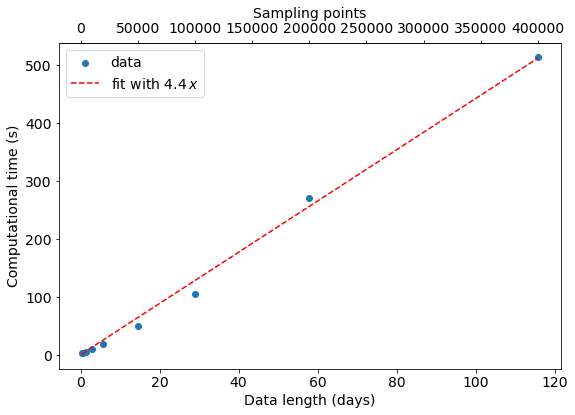

In [884]:
data_in_days = np.array( [np.array(list(mtimes.keys()))*25/86400, list(mtimes.values())] )

p = curve_fit(fit_func,*data_in_days, p0 = [1] )

fig,ax = create_plots()

ax.scatter( *data_in_days, color='C0', label='data')
smpl_x = np.arange(data_in_days[0,0], data_in_days[0,-1]+0.1, 0.1)
ax.plot( smpl_x, fit_func( smpl_x, *(p[0]) ) , linestyle='--', color='r', label=fr'fit with ${p[0][0]:.2g}\,x$')

#ax.set_xscale('log')
#ax.set_yscale('log')

secax = ax.secondary_xaxis('top',functions=( lambda x: x*86400/25, lambda x: x*86400/25))
secax.set_xlabel("Sampling points")
ax.set_xlabel("Data length (days)")
ax.set_ylabel("Computational time (s)")

ax.legend()


So the time consumption is about linear. Which is good news! We can try the same with no noise, it should go faster.

In [885]:
mtimes0={}
for smpl in samples:
    tstart = time()
    ins2 = lisainstrument.Instrument(dt=dt,size=smpl, t0=t0,
                                           aafilter=('kaiser', 240, 0.275/dt, 0.725/dt),
                                       lock = 'six',
                                       orbits='orbits.h5',
                                       gws="gw_galbin.h5")
    ins2.disable_all_noises()
    ins2.simulate()
    data2= pytdi.Data.from_instrument(ins2)

    
    built=X2.build(**data2.args)
    sig2 =  built(data2.measurements)
        
    mtimes0[smpl] = time()-tstart

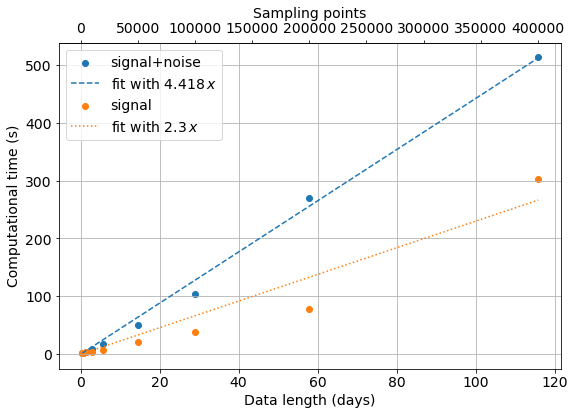

In [886]:
data0_in_days = np.array( [np.array(list(mtimes0.keys()))*25/86400, list(mtimes0.values())] )

def fit_func(x,a):
    return a*x

p = curve_fit(fit_func,*data_in_days, p0 = [1] )
p0 = curve_fit(fit_func,*data0_in_days, p0 = [1] )

fig,ax = create_plots()

ax.scatter( *data_in_days, color='C0', label='signal+noise')
smpl_x = np.arange(data_in_days[0,0], data_in_days[0,-1]+0.1, 0.1)
ax.plot( smpl_x, fit_func( smpl_x, *(p[0]) ) , linestyle='--', color='C0', label=fr'fit with ${p[0][0]:.4g}\,x$')

ax.scatter( *data0_in_days, color='C1', label='signal')
ax.plot( smpl_x, fit_func( smpl_x, *(p0[0]) ) , linestyle=':', color='C1', label=fr'fit with ${p0[0][0]:.4g}\,x$')

#ax.set_xscale('log')
#ax.set_yscale('log')

secax = ax.secondary_xaxis('top',functions=( lambda x: x*86400/25, lambda x: x*86400/25))
secax.set_xlabel("Sampling points")
ax.set_xlabel("Data length (days)")
ax.set_ylabel("Computational time (s)")

ax.grid()
ax.legend()

## Speed things up

So this is a bit faster, but still way too slow. Do we need the instrument for the signal? It seems we can get the TDI data also directly from the output of `GWResponse`. 

In [887]:
pytdi.Data.from_gws?

Signature: pytdi.Data.from_gws(path, orbits, skipped=0, neglect_tps=False)
Docstring:
Load gravitational-wave (GW) file from lisagwresponse [1].

This method reads the link responses to GWs and assume that they correspond
exactly to the noise-free inter-spacecraft (ISC) interferometric measurements.
All other measurements are assumed to be zero.

Delays are computed from an orbit file, see `Data.from_orbits()`.

    [1] https://gitlab.in2p3.fr/lisa-simulation/gw-response

Args:
    path: path to gravitational-wave file
    orbits: path to orbit file
    skipped: samples to skip the beginning [samples]
    neglect_tps: whether to use TPS PPRs or TCB LTTs
File:      ~/temp/pytdi/pytdi/interface.py
Type:      method


Loading the data from file and putting them into the structure should be fast:

In [908]:
%%time
dataf = pytdi.Data.from_gws( 'gw_galbin.h5', 'orbits.h5')

CPU times: user 738 ms, sys: 218 ms, total: 956 ms
Wall time: 1.36 s


We try the longest run from above. Note that the 'costly' part is the building of the delays. The actual calculation of the TDI variables is comparatively cheap. And it only depends on the orbits, so we can build the delays once for a given orbit and calculate the various signals much faster, as long as we do not need a different orbit.

Let's start with shorten the data obtained from the GW file a bit to have things comparable with the above scenario.

In [889]:
size=samples[-1]
for kk in ['delays', 'delay_derivatives']:
    for k,v in dataf.args[kk].items():
        dataf.args[kk][k] = dataf.args[kk][k][:size]
        
for k,v in dataf.measurements.items():
    try:
        dataf.measurements[k] = v[:size]
    except:
        pass

Calculate the delays - that is the expensive part.

In [890]:
%%time
bb  = X2.build(**dataf.args)

CPU times: user 1min 29s, sys: 32.3 s, total: 2min 2s
Wall time: 2min 2s


Even for the longest stretch, the calculations of the signal is very quick:

In [891]:
%%time
sig3 = bb(dataf.measurements) 

CPU times: user 5.97 s, sys: 650 ms, total: 6.62 s
Wall time: 6.62 s


So to get the times comparable to the above timings, we need to run through the sample sizes *backwards*, so that we can sequentially shorten them. Just to be sure, re-read the data from disk first.

In [892]:
dataf = pytdi.Data.from_gws( 'gw_galbin.h5', 'orbits.h5')

mtimes1={}
mtimes2={}
for smpl in samples[-1:0:-1]:
    
    # shorten the data
    for kk in ['delays', 'delay_derivatives']:
        for k,v in dataf.args[kk].items():
            dataf.args[kk][k] = dataf.args[kk][k][:smpl]
        
    for k,v in dataf.measurements.items():
        try:
            dataf.measurements[k] = v[:smpl]
        except:
            pass
       
    tstart=time()
    bb  = X2.build(**dataf.args)  
    tstart2 = time()
    sig3 = bb(dataf.measurements) 
    mtimes1[smpl]=time()-tstart
    mtimes2[smpl]=time()-tstart2
    
    

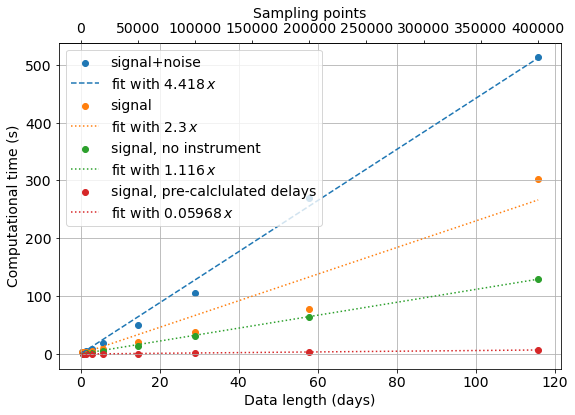

In [893]:
data1_in_days = np.array( [np.array(list(mtimes1.keys()))*25/86400, list(mtimes1.values())] )
data2_in_days = np.array( [np.array(list(mtimes2.keys()))*25/86400, list(mtimes2.values())] )

def fit_func(x,a):
    return a*x

p = curve_fit(fit_func,*data_in_days, p0 = [1] )
p0 = curve_fit(fit_func,*data0_in_days, p0 = [1] )
p1 = curve_fit(fit_func,*data1_in_days, p0 = [1] )
p2 = curve_fit(fit_func,*data2_in_days, p0 = [1] )

fig,ax = create_plots()

ax.scatter( *data_in_days, color='C0', label='signal+noise')
smpl_x = np.arange(data_in_days[0,0], data_in_days[0,-1]+0.1, 0.1)
ax.plot( smpl_x, fit_func( smpl_x, *(p[0]) ) , linestyle='--', color='C0', label=fr'fit with ${p[0][0]:.4g}\,x$')

ax.scatter( *data0_in_days, color='C1', label='signal')
ax.plot( smpl_x, fit_func( smpl_x, *(p0[0]) ) , linestyle=':', color='C1', label=fr'fit with ${p0[0][0]:.4g}\,x$')

ax.scatter( *data1_in_days, color='C2', label='signal, no instrument')
ax.plot( smpl_x, fit_func( smpl_x, *(p1[0]) ) , linestyle=':', color='C2', label=fr'fit with ${p1[0][0]:.4g}\,x$')

ax.scatter( *data2_in_days, color='C3', label='signal, pre-calclulated delays')
ax.plot( smpl_x, fit_func( smpl_x, *(p2[0]) ) , linestyle=':', color='C3', label=fr'fit with ${p2[0][0]:.4g}\,x$')

#ax.set_xscale('log')
#ax.set_yscale('log')

secax = ax.secondary_xaxis('top',functions=( lambda x: x*86400/25, lambda x: x*86400/25))
secax.set_xlabel("Sampling points")
ax.set_xlabel("Data length (days)")
ax.set_ylabel("Computational time (s)")

ax.grid()
ax.legend()

Display the values nicely as a table with `pandas`

In [894]:
import pandas as pd

In [895]:
df = pd.DataFrame( mtimes.items(), columns=['Samples','Time0'] )
df0 = pd.DataFrame( mtimes0.items(), columns=['Samples','Time1'])
df1 = pd.DataFrame( mtimes1.items(), columns=['Samples','Time2'])
df2 = pd.DataFrame( mtimes2.items(), columns=['Samples','Time3'])

In [896]:
dfa = df.join(df0.set_index('Samples'), on='Samples').join(df1.set_index('Samples'), on='Samples').join(df2.set_index('Samples'), on='Samples')

In [936]:
dfa

,Samples,Time0,Time1,Time2,Time3
0,1000,3.063176,2.776824,NaN,NaN
1,2000,3.090198,2.805423,0.465514,0.028708
2,5000,4.880645,3.572886,1.230830,0.060791
3,10000,9.032095,4.434221,2.122451,0.103258
4,20000,18.434665,7.848624,5.010856,0.236580
5,50000,50.249381,21.327022,13.711703,0.706271
6,100000,104.896677,38.729380,31.696126,1.597218
7,200000,269.397595,78.337236,63.834749,3.403700
8,400000,512.405665,302.277406,130.171373,6.991257


Can we use more than one core?

In [1058]:
from multiprocess import Pool

Read the signal and the orbits again.

In [1059]:
dataf = pytdi.Data.from_gws( 'gw_galbin.h5', 'orbits.h5')

Split it out into a number of chunks that are overlapping by a bit.

In [1060]:
def split_data( dataf, overlap = 0.001, chunks=4):
    
    def _split_chunk( ii, d ):
        m = {}
        for k, v in d.items():
            # split each item into chunks if it is an array
            if isinstance( v, np.ndarray):
                chunk_size = len(v)//chunks

                # get each chunk

                # calculate the start and the stop indices
                # make sure that the lowest start index is 0
                # and the highest stop index is the length of v

                start_ix = np.max( [ii*chunk_size-overlap_samples,0])
                stop_ix = np.min( [(ii+1)*chunk_size+overlap_samples,len(v)] )
                # print( f'Chunk: {ii}, measurement: {k}, start: {start_ix}, stop: {stop_ix}')
                m[k]= v[ start_ix : stop_ix ] 
            else:
                m[k]=v*np.ones(chunks)
        return m
        
        
    size = np.max([ v.size for v in dataf.measurements.values() if isinstance(v, np.ndarray)])
    
    # calculate the overlap of the segments
    if isinstance( overlap, int):
        overlap_samples = overlap
    else:
        overlap_samples = int(overlap*size)
        
    
    meas_new=[]
    delay_new=[]
    delay_derivatives_new=[]
    

    # iterate over the chunks
    for ii in range(chunks):
        
       
        delay={}
        delay_derivative={}
        
           
        meas_new.append( _split_chunk(ii, dataf.measurements) )
        delay_new.append( _split_chunk(ii, dataf.delays) )
        delay_derivatives_new.append( _split_chunk(ii, dataf.delay_derivatives))
      
            
           
    return [ pytdi.Data( m,d, fs=dataf.fs, delay_derivatives=dd) for m,d,dd in zip( meas_new, delay_new, delay_derivatives_new)]

In [1061]:
data_parts = split_data( dataf, overlap=1000, chunks=os.cpu_count())

Build a helper function that can be called via `map` with only the data as input. Should not be needed, but I can't figure out the right numbers of `*`

In [1067]:
def tdi_build_and_execute( data ):
    print(f"hi from {__name__}")
    bb  = X2.build(**data.args)  
    return bb(data.measurements) 
   
    

In [ ]:
with Pool() as pool: 
    result = pool.map(tdi_build_and_execute, data_parts)
    

hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__
hi from __main__


In [1056]:
f(10)

100

In [1038]:
len(dataf.measurements['isi_12'])

1261440

In [1039]:
len(data_parts[0].measurements['isi_12'])

106120

In [1036]:
len( data_parts[0].args['delays']['d_12'] )

316360

In [1041]:
Pool().map?

Init signature: map(self, /, *args, **kwargs)
Docstring:     
map(func, *iterables) --> map object

Make an iterator that computes the function using arguments from
each of the iterables.  Stops when the shortest iterable is exhausted.
Type:           type
Subclasses:     


In [1047]:
os.cpu_count()

16